In [33]:
# Importing necessary libraries
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
# Define dataset directories
base_dir = '/kaggle/input/erythrocytesdataset-sickelcelldisease/Version 2, erythrocytesIDB 2021'
erythrocytesIDB1_dir = os.path.join(base_dir, 'erythrocytesIDB1/individual cells/')
erythrocytesIDB2_dir = os.path.join(base_dir, 'erythrocytesIDB2/')
erythrocytesIDB3_dir = os.path.join(base_dir, 'erythrocytesIDB3/')

In [5]:
# Initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    print('Could not connect to TPU')
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # This strategy distributes the model across TPU cores
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if TPU not available

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1729164852.438045      13 service.cc:145] XLA service 0x56057de18670 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729164852.438099      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1729164852.438103      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1729164852.438106      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1729164852.438109      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1729164852.438112      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1729164852.438114      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1729164852.438117      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1729164852.438120      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [6]:
# Function to load and augment individual cells to reach 3000 images per class
def load_and_augment_individual_cells(data_dir, categories, target_size=4000):
    images = []
    labels = []
    augmentor = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    for category in categories:  # circular, elongated, others
        path = os.path.join(data_dir, category)
        category_images = []
        category_labels = []  # Initialize category_labels here
        
        # Load original images
        for file in os.listdir(path):
            if not file.endswith('.jpg'):
                continue
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))  # Resize to fit MobileNetV2
            category_images.append(img)
            # Assign labels (0: circular, 1: elongated, 2: others)
            if category == 'circular':
                category_labels.append(0) 
            elif category == 'elongated':
                category_labels.append(1)
            else:
                category_labels.append(2)
        
        # Convert category images to numpy array
        category_images = np.array(category_images)
        # category_labels is already a list, no need to repeat last element
        
        # Augment images if less than target_size
        if len(category_images) < target_size:
            augment_size = target_size - len(category_images)
            # Use the augmentor to generate new samples
            augmented_images = []
            augmented_labels = []
            for i in range(augment_size):
                img = category_images[i % len(category_images)]
                augmented_img = augmentor.random_transform(img)
                augmented_images.append(augmented_img)
                augmented_labels.append(category_labels[i % len(category_labels)])  # Append corresponding label
            
            # Concatenate original and augmented images
            category_images = np.concatenate([category_images, np.array(augmented_images)], axis=0)
            category_labels = category_labels + augmented_labels  # Concatenate lists directly
        
        images.append(category_images)
        labels.extend(category_labels)  # Use extend instead of append
    
    # Flatten the lists
    images = np.concatenate(images, axis=0)
    labels = np.array(labels)  # Convert labels to a numpy array
    
    return images, labels

# Load masks from erythrocytesIDB2 and erythrocytesIDB3
def load_mask_data(base_dir, sub_dirs):
    images = []
    labels = []

    for sub_dir in sub_dirs:
        data_path = os.path.join(base_dir, sub_dir)

        # Load mask images for circular, elongated, and other classes
        for mask_type in ['mask-circular.jpg', 'mask-elongated.jpg', 'mask-other.jpg']:
            img_path = os.path.join(data_path, mask_type)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))  # Resize to fit MobileNetV2
            images.append(img)
            if 'circular' in mask_type:
                labels.append(0)
            elif 'elongated' in mask_type:
                labels.append(1)
            else:
                labels.append(2)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load erythrocytesIDB1 dataset and augment to 3334 images per class
categories = ['circular', 'elongated', 'other']
images_1, labels_1 = load_and_augment_individual_cells(erythrocytesIDB1_dir, categories)

# Load erythrocytesIDB2 and erythrocytesIDB3 masks
erythrocytesIDB2_sub_dirs = [folder for folder in os.listdir(erythrocytesIDB2_dir) if folder.endswith('erythrocytesIDB2')]
images_2, labels_2 = load_mask_data(erythrocytesIDB2_dir, erythrocytesIDB2_sub_dirs)

erythrocytesIDB3_sub_dirs = [folder for folder in os.listdir(erythrocytesIDB3_dir) if folder.endswith('erythrocytesIDB3')]
images_3, labels_3 = load_mask_data(erythrocytesIDB3_dir, erythrocytesIDB3_sub_dirs)

# Combine all datasets
images = np.concatenate([images_1, images_2, images_3])
labels = np.concatenate([labels_1, labels_2, labels_3])

# Normalize images
images = images / 255.0

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=20, # reduced rotation from 40 for resnet and alexnet
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
# Now place your model code inside the strategy.scope()
with strategy.scope():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='/kaggle/input/mobilenet-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [12]:
# Train model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

/usr/local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2024-10-17 12:02:13.836133: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1729166536.898290     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3478006318f7b1bd:0:0), session_name()


  6/306 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5118 - loss: 1.1776 

I0000 00:00:1729166542.080472     819 tpu_compile_op_common.cc:245] Compilation of 3478006318f7b1bd:0:0 with session name  took 5.182135293s and succeeded
I0000 00:00:1729166542.095762     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3478006318f7b1bd:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16339522668486497126", property.function_library_fingerprint = 8391830119487179592, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,224,224,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729166542.095804     819 tpu_compilation_cache_interface.cc:541] After adding entry for key 347

305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7373 - loss: 0.6115

2024-10-17 12:03:56.790384: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1729166637.260560     766 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(92ccccc191340ad4:0:0), session_name()
I0000 00:00:1729166640.914101     766 tpu_compile_op_common.cc:245] Compilation of 92ccccc191340ad4:0:0 with session name  took 3.653489212s and succeeded
I0000 00:00:1729166640.925197     766 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(92ccccc191340ad4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1250876987203210808", property.function_library_fingerprint = 17024030878479557529, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t

306/306 ━━━━━━━━━━━━━━━━━━━━ 114s 338ms/step - accuracy: 0.7376 - loss: 0.6108 - val_accuracy: 0.8497 - val_loss: 0.3674
Epoch 2/10


I0000 00:00:1729166645.144154     785 tpu_compile_op_common.cc:245] Compilation of 8123568eeb299749:0:0 with session name  took 3.000118418s and succeeded
I0000 00:00:1729166645.152862     785 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8123568eeb299749:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1250876987203210808", property.function_library_fingerprint = 17024030878479557529, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,224,224,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729166645.152888     785 tpu_compilation_cache_interface.cc:541] After adding entry for key 812

306/306 ━━━━━━━━━━━━━━━━━━━━ 95s 302ms/step - accuracy: 0.8204 - loss: 0.4539 - val_accuracy: 0.8889 - val_loss: 0.2755
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 95s 303ms/step - accuracy: 0.8058 - loss: 0.4358 - val_accuracy: 0.9150 - val_loss: 0.2533
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 304ms/step - accuracy: 0.8398 - loss: 0.3929 - val_accuracy: 0.8824 - val_loss: 0.2686
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 95s 302ms/step - accuracy: 0.8567 - loss: 0.3598 - val_accuracy: 0.9150 - val_loss: 0.2160
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 304ms/step - accuracy: 0.8428 - loss: 0.4120 - val_accuracy: 0.9150 - val_loss: 0.2292
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 94s 300ms/step - accuracy: 0.8514 - loss: 0.3883 - val_accuracy: 0.9183 - val_loss: 0.2113
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 95s 301ms/step - accuracy: 0.8506 - loss: 0.3605 - val_accuracy: 0.9216 - val_loss: 0.1951
Epoch 9/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 306ms/step - accuracy: 0.8720 - loss: 0.3363 - val

In [17]:
# Save model
with strategy.scope():
    model.save('/kaggle/working/scd_classification_model2.keras')

In [18]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9228 - loss: 0.1652
Test accuracy: 0.915032684803009


In [19]:
from tensorflow.keras.applications import ResNet50

# Initialize ResNet50 model within strategy.scope()
with strategy.scope():
    resnet_base = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    resnet_base.trainable = False

    x = resnet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

    # Compile the model
    resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])


In [20]:
# Train ResNet50 model
resnet_history = resnet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test)
)

Epoch 1/10


2024-10-17 12:22:29.444064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1729167752.693664     771 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c368e43c97741b7d:0:0), session_name()


  4/306 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3177 - loss: 1.9247    

I0000 00:00:1729167761.125428     771 tpu_compile_op_common.cc:245] Compilation of c368e43c97741b7d:0:0 with session name  took 8.431703845s and succeeded
I0000 00:00:1729167761.143339     771 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c368e43c97741b7d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14336606611770288794", property.function_library_fingerprint = 3640738542693690596, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,224,224,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729167761.143373     771 tpu_compilation_cache_interface.cc:541] After adding entry for key c36

305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.3248 - loss: 1.2036

2024-10-17 12:24:17.950386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1729167858.581310     814 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b5e00d9b7094baf8:0:0), session_name()
I0000 00:00:1729167865.467204     814 tpu_compile_op_common.cc:245] Compilation of b5e00d9b7094baf8:0:0 with session name  took 6.885848292s and succeeded
I0000 00:00:1729167865.476325     814 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b5e00d9b7094baf8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15766192428936520586", property.function_library_fingerprint = 6304024015104490369, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t

306/306 ━━━━━━━━━━━━━━━━━━━━ 128s 367ms/step - accuracy: 0.3249 - loss: 1.2031 - val_accuracy: 0.3725 - val_loss: 1.0772
Epoch 2/10


I0000 00:00:1729167872.978482     763 tpu_compile_op_common.cc:245] Compilation of 298a76cd492763b:0:0 with session name  took 6.164353522s and succeeded
I0000 00:00:1729167872.989672     763 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(298a76cd492763b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15766192428936520586", property.function_library_fingerprint = 6304024015104490369, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,224,224,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729167872.989704     763 tpu_compilation_cache_interface.cc:541] After adding entry for key 298a7

306/306 ━━━━━━━━━━━━━━━━━━━━ 97s 308ms/step - accuracy: 0.3425 - loss: 1.0942 - val_accuracy: 0.3725 - val_loss: 1.0759
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 97s 308ms/step - accuracy: 0.3531 - loss: 1.0909 - val_accuracy: 0.3791 - val_loss: 1.0764
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 97s 307ms/step - accuracy: 0.3417 - loss: 1.0955 - val_accuracy: 0.3791 - val_loss: 1.0751
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - accuracy: 0.3642 - loss: 1.0906 - val_accuracy: 0.3791 - val_loss: 1.0744
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - accuracy: 0.3512 - loss: 1.0915 - val_accuracy: 0.3791 - val_loss: 1.0742
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 97s 308ms/step - accuracy: 0.3383 - loss: 1.0913 - val_accuracy: 0.3824 - val_loss: 1.0733
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - accuracy: 0.3254 - loss: 1.0916 - val_accuracy: 0.3791 - val_loss: 1.0725
Epoch 9/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - accuracy: 0.3758 - loss: 1.0875 - val

In [35]:
with strategy.scope():
    resnet_base = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    
    # Unfreeze the top layers for fine-tuning
    resnet_base.trainable = True
    for layer in resnet_base.layers[:-20]:
        layer.trainable = False  # Freeze all layers except the last 20

    # Add custom layers on top
    x = resnet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)
    
    resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

    # Compile the model
    resnet_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

    # Train the ResNet model
    resnet_history = resnet_model.fit(
        train_datagen.flow(X_train, y_train, batch_size=16),
        epochs=30,
        validation_data=(X_test, y_test)
    )

Epoch 1/30


2024-10-17 13:24:36.768891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1729171478.838152     763 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7feff21a5146368c:0:0), session_name()


  4/612 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.0312 - loss: 1.6341       

I0000 00:00:1729171488.011560     763 tpu_compile_op_common.cc:245] Compilation of 7feff21a5146368c:0:0 with session name  took 9.173360762s and succeeded
I0000 00:00:1729171488.032885     763 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7feff21a5146368c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11437860749994622186", property.function_library_fingerprint = 8826659423150164312, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,224,224,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729171488.032923     763 tpu_compilation_cache_interface.cc:541] After adding entry for key 7fe

610/612 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3440 - loss: 1.1255

2024-10-17 13:26:28.063972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1729171588.667413     811 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(17da318aab03aad8:0:0), session_name()
I0000 00:00:1729171596.039936     811 tpu_compile_op_common.cc:245] Compilation of 17da318aab03aad8:0:0 with session name  took 7.372474664s and succeeded
I0000 00:00:1729171596.050112     811 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(17da318aab03aad8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1562252446735058901", property.function_library_fingerprint = 9102553772970633789, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, to

612/612 ━━━━━━━━━━━━━━━━━━━━ 132s 189ms/step - accuracy: 0.3442 - loss: 1.1253 - val_accuracy: 0.2974 - val_loss: 1.2860
Epoch 2/30


I0000 00:00:1729171603.614768     748 tpu_compile_op_common.cc:245] Compilation of bc3abab82dd5094d:0:0 with session name  took 6.184350913s and succeeded
I0000 00:00:1729171603.623861     748 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bc3abab82dd5094d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1562252446735058901", property.function_library_fingerprint = 9102553772970633789, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,224,224,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729171603.623890     748 tpu_compilation_cache_interface.cc:541] After adding entry for key bc3a

612/612 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.4991 - loss: 1.0254 - val_accuracy: 0.3660 - val_loss: 2.8648
Epoch 3/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 97s 156ms/step - accuracy: 0.4287 - loss: 1.0653 - val_accuracy: 0.3072 - val_loss: 2.3877
Epoch 4/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 97s 156ms/step - accuracy: 0.4484 - loss: 1.0457 - val_accuracy: 0.3725 - val_loss: 1.0449
Epoch 5/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 97s 157ms/step - accuracy: 0.4446 - loss: 1.0238 - val_accuracy: 0.3072 - val_loss: 1.2827
Epoch 6/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.4778 - loss: 1.0295 - val_accuracy: 0.5229 - val_loss: 0.9278
Epoch 7/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.4558 - loss: 1.0456 - val_accuracy: 0.4314 - val_loss: 1.0332
Epoch 8/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 97s 155ms/step - accuracy: 0.5064 - loss: 0.9987 - val_accuracy: 0.5458 - val_loss: 0.9098
Epoch 9/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 98s 158ms/step - accuracy: 0.4985 - loss: 1.0148 - val

In [36]:
# Save ResNet50 model
with strategy.scope():
    resnet_model.save('/kaggle/working/resnet50_scd_classification_model.keras')

In [37]:
# Evaluate model
test_loss, test_accuracy = resnet_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

2024-10-17 14:17:13.154899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4212 - loss: 2.0570
Test accuracy: 0.41830065846443176


In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

# Define AlexNet model architecture within strategy.scope()
with strategy.scope():
    alexnet_model = tf.keras.Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 output classes
    ])

    # Compile AlexNet model
    alexnet_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])


/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Train AlexNet model
alexnet_history = alexnet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10


2024-10-17 12:43:14.303871: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1729168997.030781     820 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2ea7fc3accc11be3:0:0), session_name()


  5/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.1083 - loss: 3.5575       

I0000 00:00:1729169037.719632     820 tpu_compile_op_common.cc:245] Compilation of 2ea7fc3accc11be3:0:0 with session name  took 40.688806739s and succeeded
I0000 00:00:1729169037.734813     820 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2ea7fc3accc11be3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5051241900559194303", property.function_library_fingerprint = 521372338993925213, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,224,224,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729169037.734849     820 tpu_compilation_cache_interface.cc:541] After adding entry for key 2ea7

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3392 - loss: 1.2721

2024-10-17 12:45:33.280243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1729169133.537617     767 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a808a6bba00110c4:0:0), session_name()
I0000 00:00:1729169136.692073     767 tpu_compile_op_common.cc:245] Compilation of a808a6bba00110c4:0:0 with session name  took 3.15436878s and succeeded
I0000 00:00:1729169136.694757     767 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a808a6bba00110c4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14702103038671338562", property.function_library_fingerprint = 7564642678385772911, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, to

306/306 ━━━━━━━━━━━━━━━━━━━━ 150s 344ms/step - accuracy: 0.3392 - loss: 1.2716 - val_accuracy: 0.3529 - val_loss: 1.0970
Epoch 2/10


I0000 00:00:1729169142.761973     806 tpu_compile_op_common.cc:245] Compilation of fa5ea922822d20ae:0:0 with session name  took 5.079332009s and succeeded
I0000 00:00:1729169142.764449     806 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(fa5ea922822d20ae:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14702103038671338562", property.function_library_fingerprint = 7564642678385772911, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,224,224,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729169142.764485     806 tpu_compilation_cache_interface.cc:541] After adding entry for key fa5

306/306 ━━━━━━━━━━━━━━━━━━━━ 95s 301ms/step - accuracy: 0.3400 - loss: 1.0992 - val_accuracy: 0.3595 - val_loss: 1.0972
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 95s 301ms/step - accuracy: 0.3262 - loss: 1.0994 - val_accuracy: 0.3595 - val_loss: 1.0995
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - accuracy: 0.3246 - loss: 1.0996 - val_accuracy: 0.3529 - val_loss: 1.0979
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - accuracy: 0.3303 - loss: 1.1000 - val_accuracy: 0.3529 - val_loss: 1.1006
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 304ms/step - accuracy: 0.3165 - loss: 1.0997 - val_accuracy: 0.3529 - val_loss: 1.1005
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 97s 308ms/step - accuracy: 0.3255 - loss: 1.1012 - val_accuracy: 0.2876 - val_loss: 1.0996
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 305ms/step - accuracy: 0.3205 - loss: 1.0987 - val_accuracy: 0.2876 - val_loss: 1.1005
Epoch 9/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 95s 301ms/step - accuracy: 0.3535 - loss: 1.0976 - val

In [38]:
with strategy.scope():
    alexnet_input = tf.keras.Input(shape=(224, 224, 3))
    
    # Define AlexNet-like architecture
    x = tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(alexnet_input)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    alexnet_output = tf.keras.layers.Dense(3, activation='softmax')(x)

    alexnet_model = Model(inputs=alexnet_input, outputs=alexnet_output)

    # Compile the AlexNet-like model
    alexnet_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

    # Train the AlexNet model
    alexnet_history = alexnet_model.fit(
        train_datagen.flow(X_train, y_train, batch_size=16),
        epochs=20,
        validation_data=(X_test, y_test)
    )

Epoch 1/20


2024-10-17 14:30:26.099871: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1729175427.725697     822 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(32f616cb267ea358:0:0), session_name()


  4/612 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.7604 - loss: 1.0853   

I0000 00:00:1729175442.327515     822 tpu_compile_op_common.cc:245] Compilation of 32f616cb267ea358:0:0 with session name  took 14.601744849s and succeeded
I0000 00:00:1729175442.343220     822 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(32f616cb267ea358:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14568089470844017897", property.function_library_fingerprint = 9609535810380794991, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,224,224,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729175442.343256     822 tpu_compilation_cache_interface.cc:541] After adding entry for key 32

611/612 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3595 - loss: 1.1018

2024-10-17 14:32:22.470830: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1729175542.677177     812 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6c20e039d3f47f5d:0:0), session_name()
I0000 00:00:1729175545.884822     812 tpu_compile_op_common.cc:245] Compilation of 6c20e039d3f47f5d:0:0 with session name  took 3.207581518s and succeeded
I0000 00:00:1729175545.888191     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6c20e039d3f47f5d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15780214971464485524", property.function_library_fingerprint = 1160182837328352002, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t

612/612 ━━━━━━━━━━━━━━━━━━━━ 128s 179ms/step - accuracy: 0.3594 - loss: 1.1018 - val_accuracy: 0.3595 - val_loss: 1.0937
Epoch 2/20


I0000 00:00:1729175551.950225     789 tpu_compile_op_common.cc:245] Compilation of 53c0bff546ff0eec:0:0 with session name  took 4.958035467s and succeeded
I0000 00:00:1729175551.952750     789 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(53c0bff546ff0eec:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15780214971464485524", property.function_library_fingerprint = 1160182837328352002, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,224,224,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1729175551.952781     789 tpu_compilation_cache_interface.cc:541] After adding entry for key 53c

612/612 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.3587 - loss: 1.0955 - val_accuracy: 0.3529 - val_loss: 1.0985
Epoch 3/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.3187 - loss: 1.1046 - val_accuracy: 0.3627 - val_loss: 1.0974
Epoch 4/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.3575 - loss: 1.0980 - val_accuracy: 0.3693 - val_loss: 1.0736
Epoch 5/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 101s 163ms/step - accuracy: 0.3173 - loss: 1.0944 - val_accuracy: 0.3725 - val_loss: 1.0770
Epoch 6/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 99s 160ms/step - accuracy: 0.3294 - loss: 1.0889 - val_accuracy: 0.3072 - val_loss: 1.0766
Epoch 7/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.3294 - loss: 1.0913 - val_accuracy: 0.3758 - val_loss: 1.0840
Epoch 8/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.3422 - loss: 1.0899 - val_accuracy: 0.3693 - val_loss: 1.0703
Epoch 9/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.3292 - loss: 1.095

In [1]:
# Save AlexNet model
with strategy.scope():
    alexnet_model.save('/kaggle/working/alexnet_scd_classification_model.keras')

NameError: name 'strategy' is not defined

In [29]:
# Evaluate model
test_loss, test_accuracy = alexnet_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3521 - loss: 1.0983
Test accuracy: 0.3529411852359772


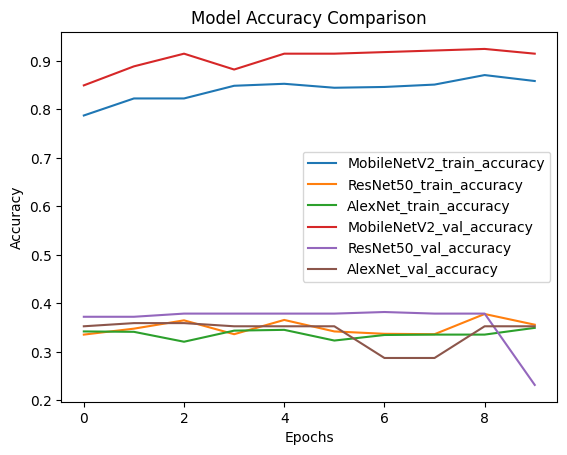

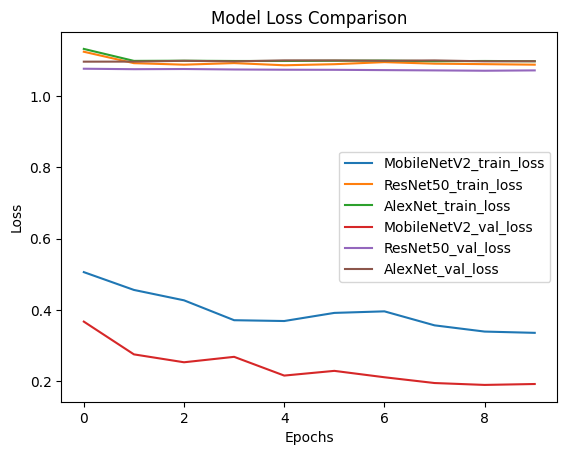

In [30]:
# Compare accuracy of all models
plt.plot(history.history['accuracy'], label='MobileNetV2_train_accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet50_train_accuracy')
plt.plot(alexnet_history.history['accuracy'], label='AlexNet_train_accuracy')

plt.plot(history.history['val_accuracy'], label='MobileNetV2_val_accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50_val_accuracy')
plt.plot(alexnet_history.history['val_accuracy'], label='AlexNet_val_accuracy')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Similarly, plot the loss for comparison
plt.plot(history.history['loss'], label='MobileNetV2_train_loss')
plt.plot(resnet_history.history['loss'], label='ResNet50_train_loss')
plt.plot(alexnet_history.history['loss'], label='AlexNet_train_loss')

plt.plot(history.history['val_loss'], label='MobileNetV2_val_loss')
plt.plot(resnet_history.history['val_loss'], label='ResNet50_val_loss')
plt.plot(alexnet_history.history['val_loss'], label='AlexNet_val_loss')

plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

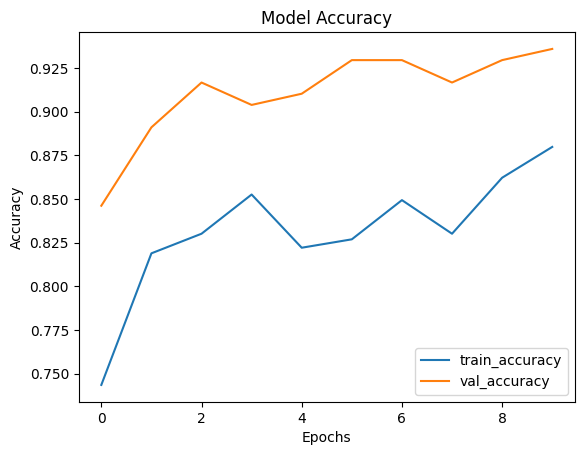

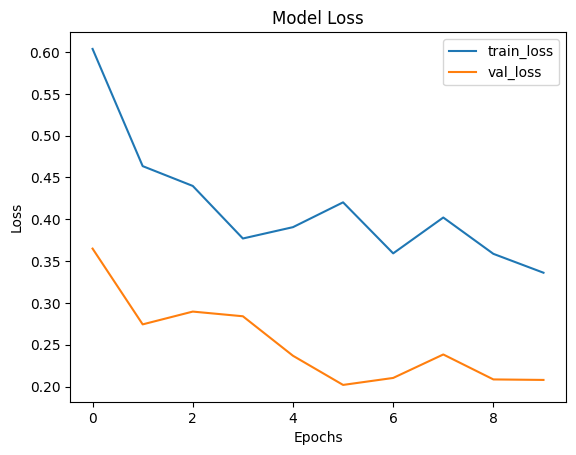

In [18]:
# Plot Accuracy and Loss
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2024-10-14 11:39:26.042791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/Conv1_1/convolution/ReadVariableOp.
I0000 00:00:1728905966.327034     831 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7afc9a2fde6e0d7b:0:0), session_name()


1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

I0000 00:00:1728905969.711429     831 tpu_compile_op_common.cc:245] Compilation of 7afc9a2fde6e0d7b:0:0 with session name  took 3.384347776s and succeeded
I0000 00:00:1728905969.721895     831 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7afc9a2fde6e0d7b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_18359452336123506152", property.function_library_fingerprint = 15273912530147055983, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728905969.721924     831 tpu_compilation_cache_interface.cc:541] After adding entry for key 7afc9a2fde

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step


I0000 00:00:1728905974.910889     806 tpu_compile_op_common.cc:245] Compilation of e5db75303cd915d9:0:0 with session name  took 3.482179358s and succeeded
I0000 00:00:1728905974.921399     806 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e5db75303cd915d9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9768104554763883092", property.function_library_fingerprint = 7291358451222112235, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,224,224,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728905974.921431     806 tpu_compilation_cache_interface.cc:541] After adding entry for key

Accuracy for these 50 random images: 94.0%
Total correct predictions: 47
Total incorrect predictions: 3


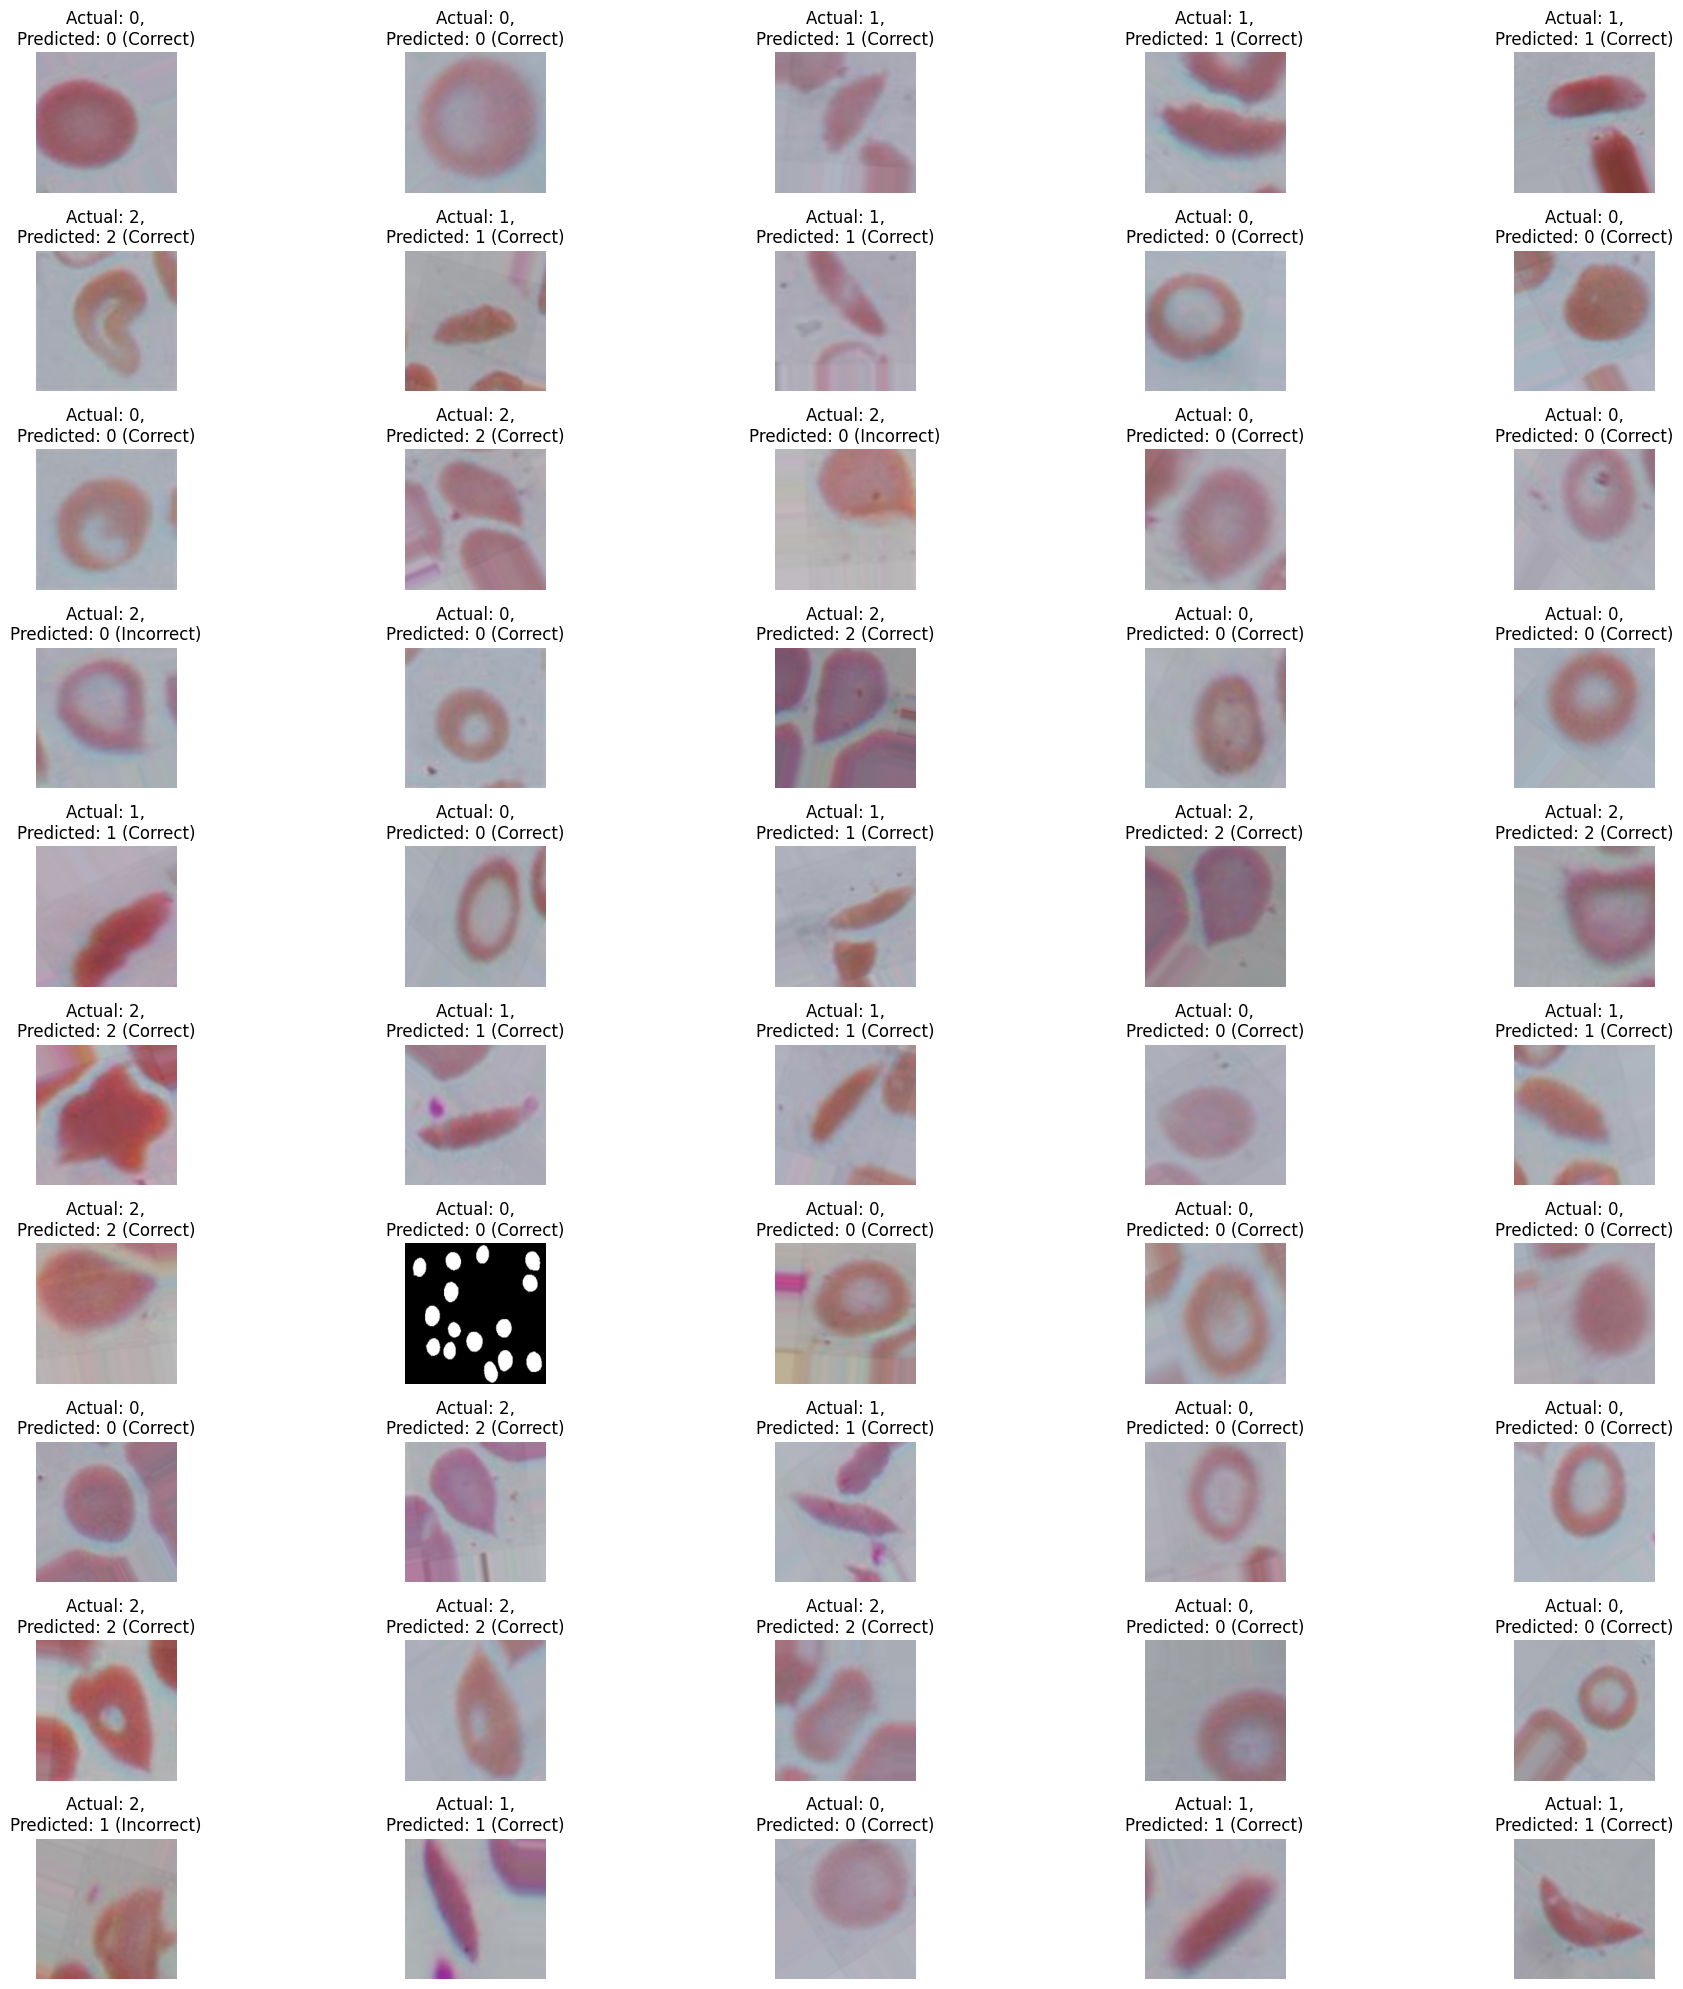

In [19]:
# ------------------- Generate Predictions for 50 Random Images -------------------

# Select 50 random indices
random_indices = random.sample(range(len(X_test)), 50)

# Extract the corresponding test images and actual labels
random_images = X_test[random_indices]
random_actual_labels = y_test[random_indices]

# Predict labels for the random images
predicted_labels = model.predict(random_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate accuracy for the 50 random images
correct_predictions = np.sum(predicted_labels == random_actual_labels)
incorrect_predictions = 50 - correct_predictions
accuracy_50_images = correct_predictions / 50 * 100
print(f"Accuracy for these 50 random images: {accuracy_50_images}%")
print(f"Total correct predictions: {correct_predictions}")
print(f"Total incorrect predictions: {incorrect_predictions}")

# Display the actual vs predicted labels with images (5 images per row)
plt.figure(figsize=(20, 20))  # Adjust size for better visualization
for i in range(50):  # Display 50 images, 5 per row
    plt.subplot(10, 5, i + 1)  # 10 rows, 5 columns
    plt.imshow(random_images[i])
    
    # Check if prediction is correct or incorrect
    result = "Correct" if random_actual_labels[i] == predicted_labels[i] else "Incorrect"
    
    plt.title(f"Actual: {random_actual_labels[i]},\nPredicted: {predicted_labels[i]} ({result})")
    plt.axis('off')  # Hide axes for a cleaner look
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Accuracy for these 50 random images: 92.0%
Total correct predictions: 46
Total incorrect predictions: 4


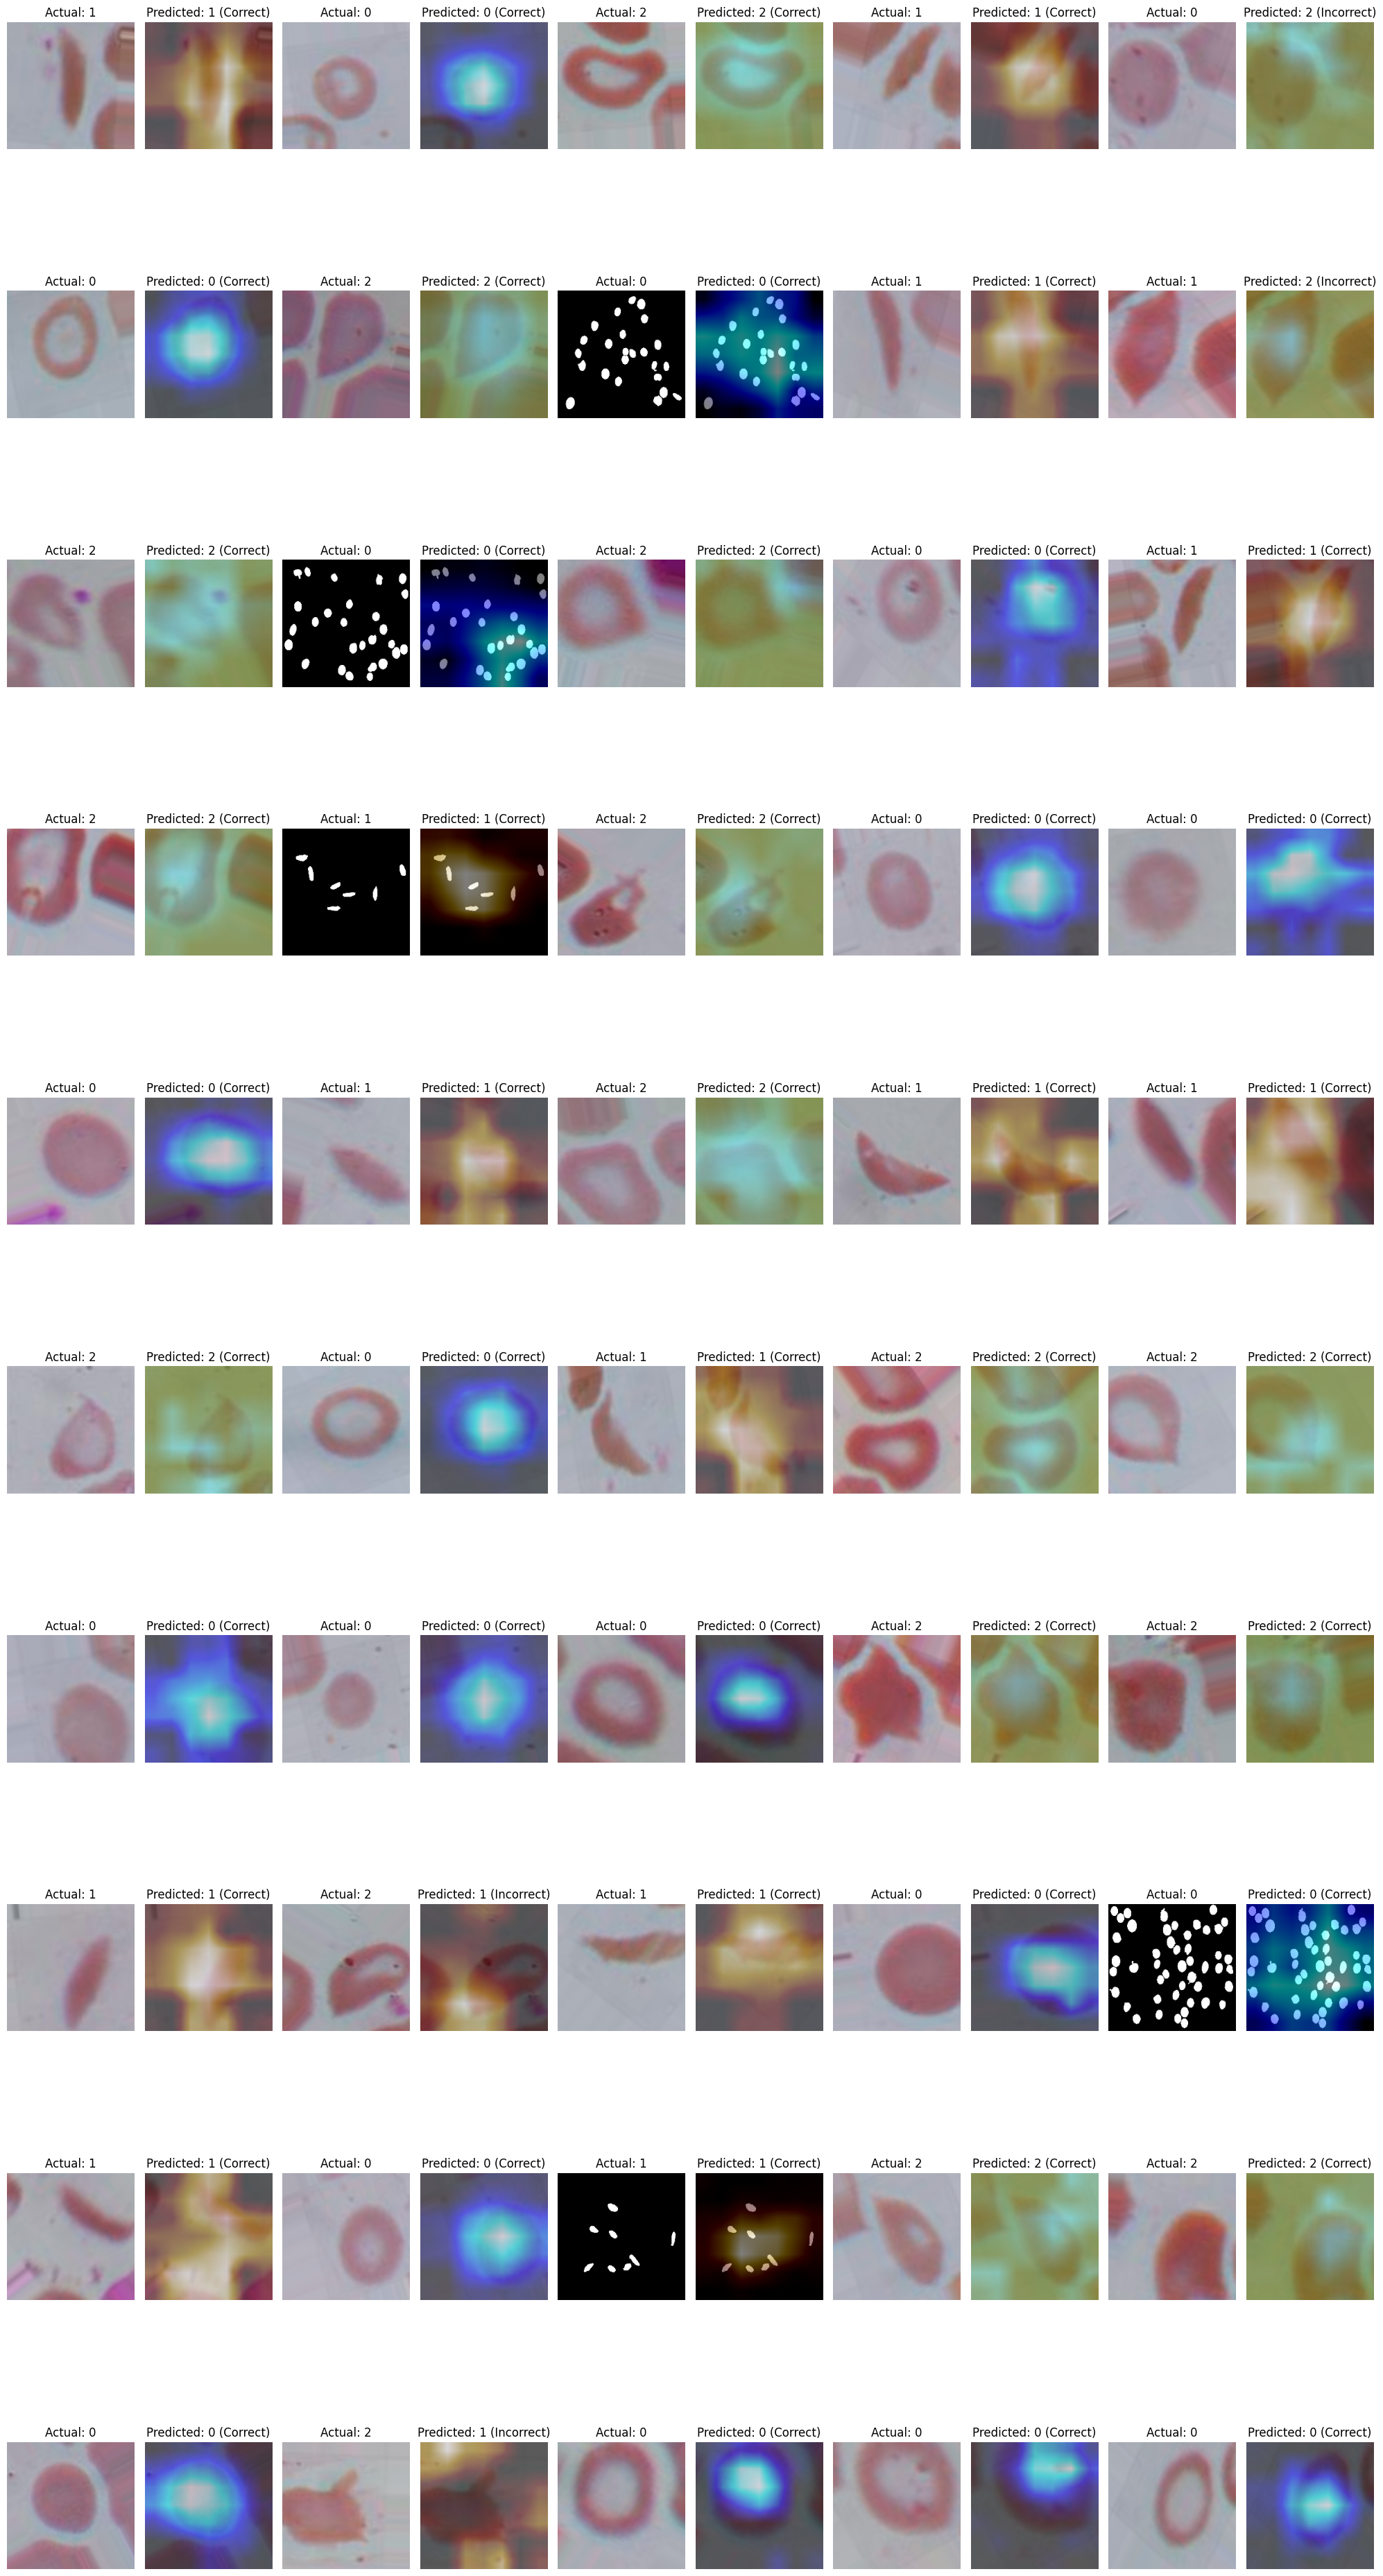

In [22]:
# Function to overlay Grad-CAM heatmap on the image
def overlay_heatmap(img, heatmap, intensity=0.5, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match the size of the image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to color
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Convert original image to uint8 (from float32)
    img_uint8 = np.uint8(255 * img)

    # Overlay heatmap on image
    overlay_img = cv2.addWeighted(heatmap, intensity, img_uint8, 1 - intensity, 0)
    return overlay_img

# ------------------- Generate Predictions for 50 Random Images -------------------

# Select 50 random indices
random_indices = random.sample(range(len(X_test)), 50)

# Extract the corresponding test images and actual labels
random_images = X_test[random_indices]
random_actual_labels = y_test[random_indices]

# Predict labels for the random images
predicted_labels = model.predict(random_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate accuracy for the 50 random images
correct_predictions = np.sum(predicted_labels == random_actual_labels)
incorrect_predictions = 50 - correct_predictions
accuracy_50_images = correct_predictions / 50 * 100
print(f"Accuracy for these 50 random images: {accuracy_50_images}%")
print(f"Total correct predictions: {correct_predictions}")
print(f"Total incorrect predictions: {incorrect_predictions}")

# Display images with Grad-CAM heatmaps and actual vs predicted labels (5 images per row)
plt.figure(figsize=(20, 40))

for i in range(50):
    # Plot original image
    plt.subplot(10, 10, i * 2 + 1)  # Original images in odd positions
    plt.imshow(random_images[i])
    plt.title(f"Actual: {random_actual_labels[i]}")
    plt.axis('off')

    # Preprocess image for model input
    img = np.expand_dims(random_images[i], axis=0)
    
    # Generate Grad-CAM heatmap for predicted class
    heatmap = get_gradcam_heatmap(model, img, predicted_labels[i])

    # Overlay heatmap on original image (using different colormaps for each class)
    if predicted_labels[i] == 0:  # Circular
        colormap = cv2.COLORMAP_HOT
    elif predicted_labels[i] == 1:  # Elongated
        colormap = cv2.COLORMAP_OCEAN
    else:  # Others
        colormap = cv2.COLORMAP_SUMMER

    overlay_img = overlay_heatmap(random_images[i], heatmap, colormap=colormap)

    # Check if prediction is correct or incorrect
    result = "Correct" if random_actual_labels[i] == predicted_labels[i] else "Incorrect"

    # Plot the overlaid image with actual and predicted labels
    plt.subplot(10, 10, i * 2 + 2)  # Overlaid images in even positions
    plt.imshow(overlay_img)
    plt.title(f"Predicted: {predicted_labels[i]} ({result})")
    plt.axis('off')

plt.tight_layout()
plt.show()
